In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import itertools as it

J = -1
k = 1.380649/1e23

In [6]:
class lattice:
    def __init__(self, ndims, length, temp): # If want non-square lattice, make length an array/tuple
        self.ndims = ndims
        self.length = length
        self.temp = temp
        # np.full creates an array of length ndims with values of length, to create the size tuple
        # Change to size=length for non-square lattice
        self.points = np.random.choice(a=[-1, 1], size=tuple(np.full(ndims, length, dtype=int)))
        self.erg = 0
        self.mag = np.sum(self.points) / self.length**self.ndims # Change to product along entries of length for non-square lattice

    def update_E(self):
        energy = 0
        # itertools.product creates the adjacent and diagonal neighbors of any ndarray point
        for index in it.product(range(-1,self.length-1), repeat=self.ndims): # If want non-square lattice, make product over different ranges()
            neighbors = []
            for rel_pos in it.product((-1, 0, 1), repeat=self.ndims): # Loop over all neighbors. 
                # Exclude the point itself and all diagonal neighbors
                if not all(i == 0 for i in rel_pos) and not all(i != 0 for i in rel_pos): 
                    neighbors.append(self.points[tuple(i + i_rel for i, i_rel in zip(index, rel_pos))]) # Add neighbor spin values
            neighbors = np.array(neighbors)
            energy += J * np.sum(neighbors * self.points[index]) # Add to energy
        self.erg = energy / 2 # divide by 2 for double-counting
        
    def update_M(self): # Update magnetization
        self.mag = np.sum(self.points) / self.length**self.ndims

    def set_points(self, value): # Make spins uniform for testing
        self.points = np.random.choice(a=[value], size=tuple(np.full(self.ndims, self.length, dtype=int)))

In [22]:
L1 = lattice(2,25,273)
print(L1.points)
L1.update_E()
print(L1.erg)
print(L1.mag)

[[-1 -1 -1 -1 -1  1  1  1 -1  1 -1 -1 -1  1 -1 -1  1 -1  1 -1  1  1 -1 -1
   1]
 [-1 -1 -1  1 -1 -1 -1  1  1 -1  1  1  1  1 -1 -1  1 -1 -1  1 -1  1 -1 -1
  -1]
 [-1  1  1 -1 -1 -1  1 -1 -1 -1 -1  1  1  1  1 -1 -1  1 -1  1  1 -1 -1  1
   1]
 [-1  1  1 -1 -1 -1  1  1  1 -1  1 -1  1 -1 -1  1 -1 -1 -1 -1  1 -1 -1 -1
  -1]
 [-1 -1 -1 -1  1  1 -1  1 -1  1  1 -1 -1 -1 -1  1 -1 -1  1  1 -1 -1 -1 -1
  -1]
 [-1 -1 -1 -1 -1  1  1  1  1  1  1  1 -1 -1  1  1  1 -1 -1  1  1  1  1  1
   1]
 [ 1  1  1 -1 -1  1  1  1 -1 -1 -1 -1 -1  1  1 -1  1  1 -1  1 -1  1 -1  1
   1]
 [ 1  1 -1  1 -1  1  1 -1 -1 -1 -1 -1  1 -1 -1 -1  1 -1 -1 -1 -1 -1  1  1
   1]
 [-1 -1  1  1 -1  1 -1 -1  1  1 -1 -1 -1  1  1 -1 -1  1  1 -1 -1  1  1 -1
  -1]
 [ 1  1  1 -1 -1  1  1  1 -1 -1 -1 -1 -1 -1 -1  1 -1  1  1  1 -1 -1  1  1
  -1]
 [-1 -1 -1  1  1  1  1  1 -1  1 -1  1  1  1  1 -1 -1  1 -1  1  1 -1 -1 -1
   1]
 [-1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1  1 -1  1  1 -1 -1  1  1 -1 -1  1  1  1
  -1]
 [ 1  1 -1  1  1  1  1 -1  1 -1 -1  1  1

In [ ]:
L1 = lattice(2,2,273) 
# Code faulty for matrix with length==2, neighbor indices quadruple count rather than double count. 
# Is a problem when matrix values are uniform
L1.set_points(-1)
print(L1.points)
L1.update_E()
print(L1.erg)
print(L1.mag)

[[-1 -1]
 [-1 -1]]
-8.0
0.0


In [12]:
def metropolis(lattice, n_steps):
    mag = []
    erg = []
    for ii in range(0,n_steps):
        init_E = lattice.erg
        rand_index = tuple(np.random.choice(a=lattice.length, size=lattice.ndims))
        lattice.points[rand_index] = -1 * lattice.points[rand_index]
        lattice.update_E()
        fin_E = lattice.erg
        del_E = fin_E - init_E
        if del_E > 0 and np.random.rand() > np.exp(-1 * del_E/(k * lattice.temp)):
            lattice.points[rand_index] = -1 * lattice.points[rand_index]
        lattice.update_E()
        lattice.update_M()
        erg.append(lattice.erg)
        mag.append(lattice.mag)
    mag, erg = np.array(mag), np.array(erg)
    return np.array([erg, mag])

Text(0, 0.5, 'Magnetization ()')

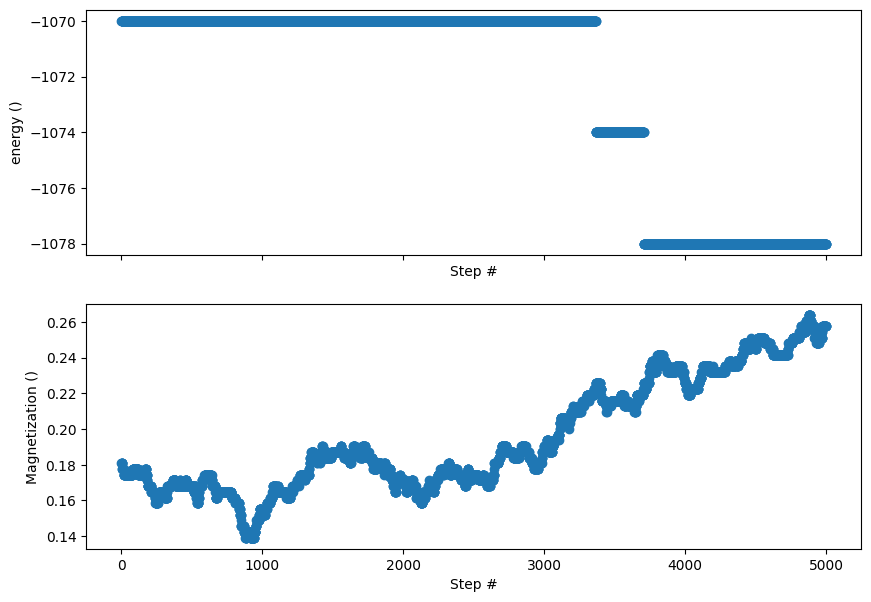

In [26]:
n_steps = 5000
steps = range(0,n_steps)
erg, mag = metropolis(L1, n_steps)
fig, axes = plt.subplots(2, 1, figsize=(10, 7), sharex=True)
ax = axes[0]
ax.scatter(steps,erg)
ax.set_xlabel("Step #")
ax.set_ylabel("energy ()")
ax = axes[1]
ax.scatter(steps,mag)
ax.set_xlabel("Step #")
ax.set_ylabel("Magnetization ()")

In [3]:
print(np.random.choice(a=5, size=3))

[2 0 4]
